<a href="https://colab.research.google.com/github/Sudorenkoroma/HW_GI_ML/blob/main/HW_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [14]:
# Завантаження та попередня обробка датасету Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Нормалізація зображень
train_images = train_images / 255.0
test_images = test_images / 255.0

# Розширення зображень до 3 каналів для відповідності VGG16
train_images = np.stack([train_images]*3, axis=-1)
test_images = np.stack([test_images]*3, axis=-1)

# Зміна розміру зображень до 48x48 для відповідності VGG16
train_images = tf.image.resize(train_images, (48, 48))
test_images = tf.image.resize(test_images, (48, 48))

In [15]:
# Використання VGG16 без верхніх шарів
vgg16_base = VGG16(include_top=False, input_shape=(48, 48, 3), weights='imagenet')

# Розморожуємо декілька верхніх шарів базової моделі VGG16 для донавчання
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

# Додавання нових шарів для класифікації
model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Компільовання моделі з меншою швидкістю навчання для донавчання
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Відображення структури моделі
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                      

In [18]:
# Використання Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.1,
    shear_range=0.3,
    width_shift_range=0.08,
    height_shift_range=0.08,
    vertical_flip=True,
    horizontal_flip=True  # Додавання горизонтального відображення
)
datagen.fit(train_images)

# Рання зупинка
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Збереження найкращої моделі
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='min')


In [19]:
# Навчання моделі з використанням ранньої зупинки та збереження найкращої моделі
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=50,
                    validation_data=(test_images, test_labels),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/50
938/938 [==============================] - 67s 72ms/step - loss: 0.2225 - accuracy: 0.9193 - val_loss: 0.2418 - val_accuracy: 0.9135
Epoch 2/50
938/938 [==============================] - 70s 74ms/step - loss: 0.2193 - accuracy: 0.9217 - val_loss: 0.2377 - val_accuracy: 0.9161
Epoch 3/50
938/938 [==============================] - 67s 71ms/step - loss: 0.2126 - accuracy: 0.9245 - val_loss: 0.2363 - val_accuracy: 0.9161
Epoch 4/50
938/938 [==============================] - 66s 71ms/step - loss: 0.2085 - accuracy: 0.9248 - val_loss: 0.2493 - val_accuracy: 0.9154
Epoch 5/50
938/938 [==============================] - 66s 70ms/step - loss: 0.2086 - accuracy: 0.9254 - val_loss: 0.2450 - val_accuracy: 0.9130
Epoch 6/50
938/938 [==============================] - 65s 70ms/step - loss: 0.2055 - accuracy: 0.9261 - val_loss: 0.2307 - val_accuracy: 0.9214
Epoch 7/50
938/938 [==============================] - 66s 70ms/step - loss: 0.2015 - accuracy: 0.9272 - val_loss: 0.2360 - val_accuracy:

In [20]:
# Завантаження найкращої збереженої моделі
model.load_weights('best_model.h5')

# Оцінка моделі на тестовому наборі після донавчання
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy after fine-tuning: {test_acc}')

313/313 - 4s - loss: 0.2616 - accuracy: 0.9113 - 4s/epoch - 13ms/step

Test accuracy after fine-tuning: 0.911300003528595


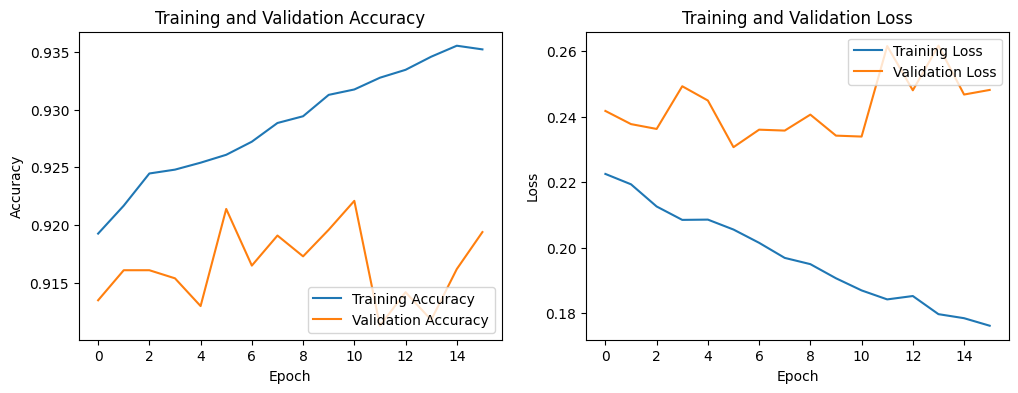

In [21]:
# Візуалізація результатів навчання
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


313/313 [==============================] - 5s 16ms/step


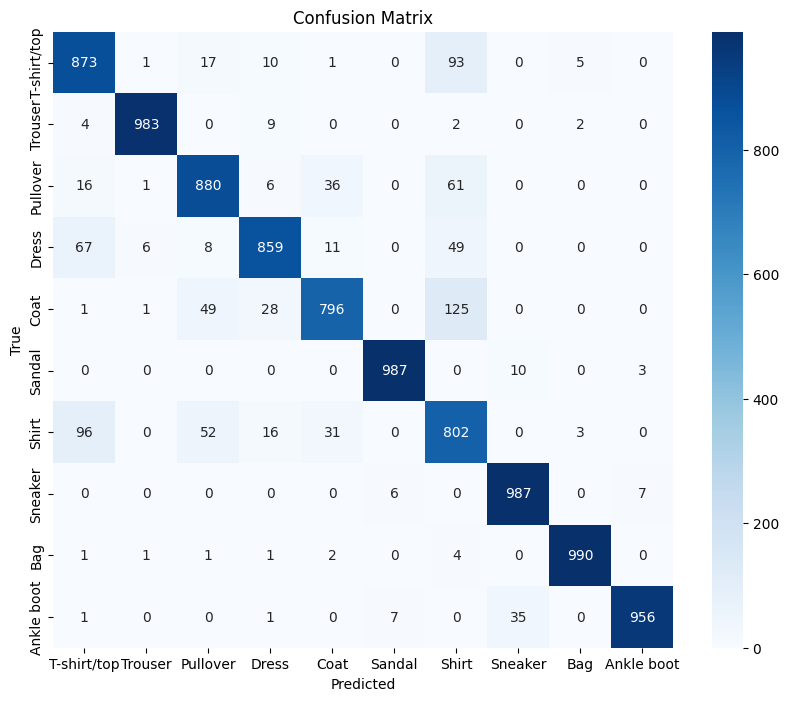

In [22]:
#  Прогнозування
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Матриця плутанини
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Відображення матриці плутанини
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Класифікаційний звіт
print(classification_report(test_labels, predicted_labels, target_names=class_names))


              precision    recall  f1-score   support

 T-shirt/top       0.82      0.87      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.88      0.88      1000
       Dress       0.92      0.86      0.89      1000
        Coat       0.91      0.80      0.85      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.71      0.80      0.75      1000
     Sneaker       0.96      0.99      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.99      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



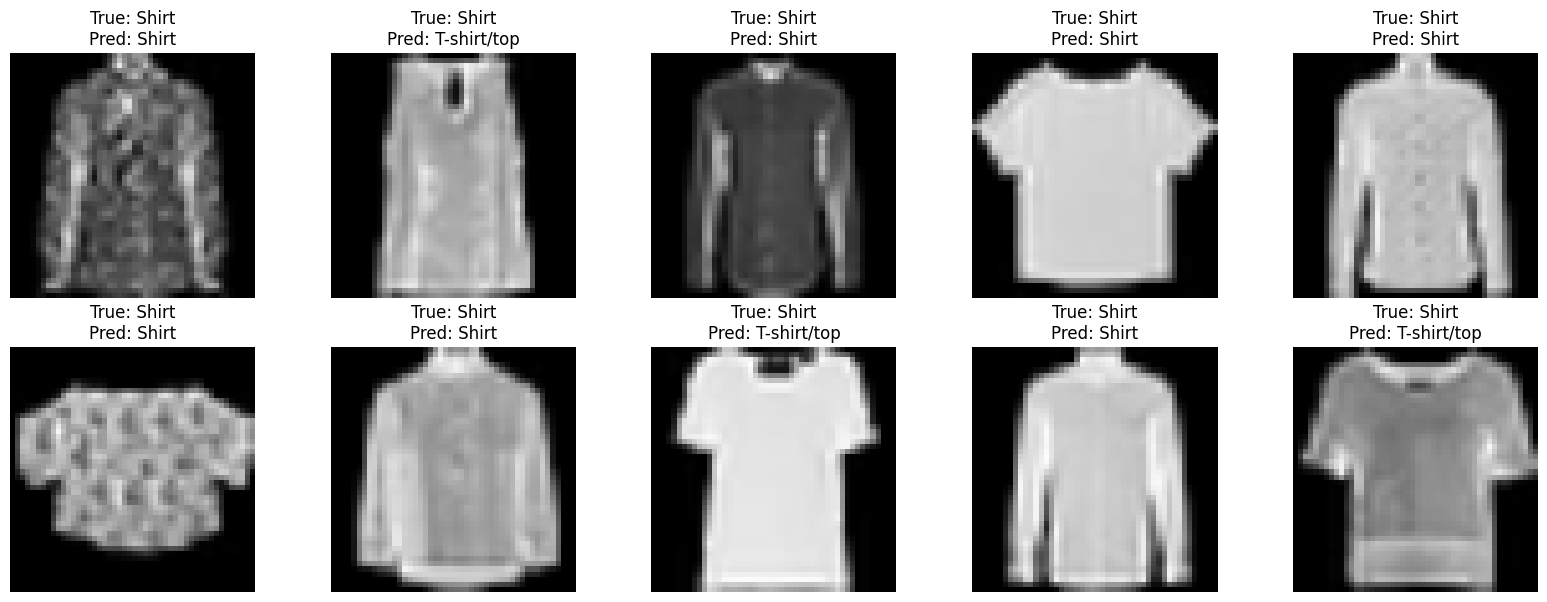

In [26]:
# Відображення 10 прикладів футболок з правильними та передбаченими мітками
shirt_indices = np.where(test_labels == 6)[0]  # 'Shirt' є 6 класом
sample_shirt_indices = np.random.choice(shirt_indices, 10, replace=False)

plt.figure(figsize=(20, 7))
for i, index in enumerate(sample_shirt_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[index].numpy().reshape(48, 48, 3))
    plt.title(f"True: {class_names[test_labels[index]]}\nPred: {class_names[predicted_labels[index]]}")
    plt.axis('off')

plt.show()

In [ ]:
# Особисто в мене враження ніби модень передбачає зображення краще, чим той хто виставляв ці мітки.